In [32]:
import iris
import warnings
import iris.plot as iplt
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

In [21]:
path = "/short/tp28/eh6215/daily/"
trials = {"EA":"cg282_easyaerosol","r6":"cg282_fb_convect","noEA":"cg282_noeasyaerosol","radEA":"cg282_radeasyaerosol",'agcd':'agcd'}
yearmons=['201210','201211','201212','201301','201302','201303','201304','201305','201306','201307']
cy = iris.Constraint(latitude=lambda y:-45<=y<=-10)
cx = iris.Constraint(longitude=lambda x: 111<=x<=155)


In [22]:
data={}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for trial in trials:
        data[trial] = iris.load([path+trials[trial]+"/%s.nc"%ym for ym in yearmons],['prcp','agcd_precip']).extract(cx&cy)
        iris.util.equalise_attributes(data[trial])
        data[trial]=data[trial].concatenate_cube()

In [26]:
data["agcd"].units='mm/day'
mask = (data['agcd'].data < 2).all(axis=0).filled(1)
for name in trials:
    data[name].data.mask+=mask




/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'doyr'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris

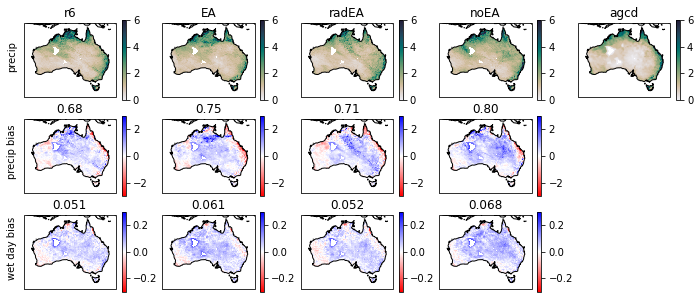

In [46]:
agcd_mean=data['agcd'].collapsed('time',iris.analysis.MEAN)
agcd_raindays = data['agcd'].collapsed('time',iris.analysis.PROPORTION,function=lambda x:x>1)
figure=plt.figure(figsize=(12,5))
for i,trial in enumerate(['r6','EA','radEA','noEA','agcd']):
    ax=plt.subplot(3,5,i+1,projection=ccrs.PlateCarree())
    iplt.pcolormesh(data[trial].collapsed('time',iris.analysis.MEAN),vmin=0,vmax=6,cmap=cmocean.cm.rain)
    ax.coastlines()
    plt.title(trial)
    plt.colorbar()
    if i==0:
            ax.text(-0.07, 0.55, 'precip', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax.transAxes)
    if trial != 'agcd':
        ax=plt.subplot(3,5,i+6,projection=ccrs.PlateCarree())
        iplt.pcolormesh(data[trial].collapsed('time',iris.analysis.MEAN) - agcd_mean.data,vmin=-3,vmax=3,cmap="bwr_r")
        rmse = np.sqrt(((data[trial].collapsed('time',iris.analysis.MEAN).data -agcd_mean.data)**2).mean())
        plt.title("%0.2f"%rmse)
        ax.coastlines()
        if i==0:
            ax.text(-0.07, 0.55, 'precip bias', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax.transAxes)
        plt.colorbar()
        ax=plt.subplot(3,5,i+11,projection=ccrs.PlateCarree())
        iplt.pcolormesh(data[trial].collapsed('time',iris.analysis.PROPORTION,function=lambda x:x>1) - agcd_raindays.data,vmin=-0.3,vmax=0.3,cmap="bwr_r")
        rmse = np.sqrt(((data[trial].collapsed('time',iris.analysis.PROPORTION,function=lambda x:x>1).data -agcd_raindays.data)**2).mean())
        plt.title("%0.3f"%rmse)
        ax.coastlines()
        if i==0:
            ax.text(-0.07, 0.55, 'wet day bias', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax.transAxes)
        plt.colorbar()        
                    

0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0


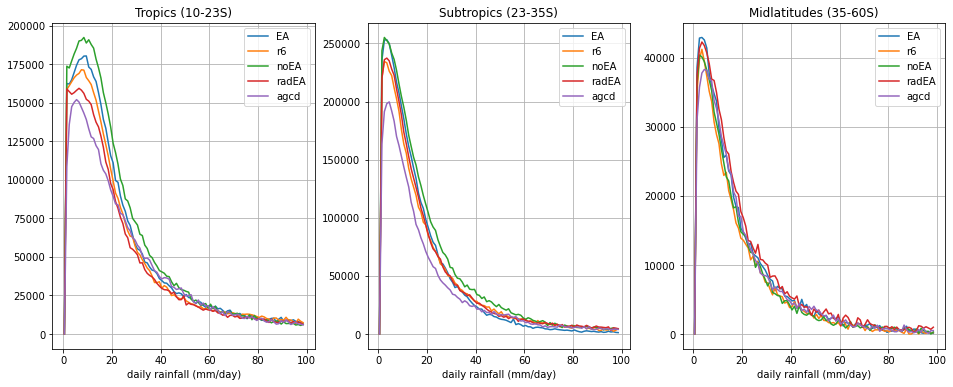

In [53]:

plt.figure(figsize=(16,6))
for k,bins in enumerate([np.arange(0,100,1)]):#,np.arange(0,200,2),np.arange(0,1200,20)]):
  for j,(y1,y2) in enumerate([(-10,-23),(-23,-35),(-35,-60)]):
    plt.subplot(1,3,j+1+k*3)
    cy = iris.Constraint(latitude=lambda y: y1>=y>=y2)
    plt.title(["Tropics (10-23S)","Subtropics (23-35S)","Midlatitudes (35-60S)"][j])
    plt.xlabel("daily rainfall (mm/day)")
    #for i,name in enumerate(["r1",'r2',"r4","agcd"]):
    for i,name in enumerate(trials):
        print(i,j,k)
        h,b=np.histogram([x for x in data[name].extract(cy)[:].data.flatten().filled(np.nan) if not np.isnan(x)],bins=bins)
#        plt.hist(data[name].extract(cy).data.flatten(),bins=np.arange(0,100,2),label=name,histtype="step")
#        h = gaussian_filter1d(h,5)
        plt.plot((b[1:]+b[:-1])/2,h*b[:-1],label=name)
#    plt.xlim(0,[1000,600,420][j])
    plt.grid()
    plt.legend()
#    plt.semilogy()

plt.show()
